In [36]:
%pip install statsmodels


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots

1

In [38]:
data = pd.read_csv(r"D:\Рабочий стол\Мэг_питон\ML\Базы данных\AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [39]:
data.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [40]:
# изменение типа столбца с object на datetime
data['Month'] = pd.to_datetime(data['Month'], format="%Y-%m")

In [41]:
data.set_index('Month', inplace=True) # установили индекс таблицы равным Month
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [42]:
data.index.is_monotonic_increasing 
# проверка, в хронологическом ли порядке расположены даты

True

Данные монотонно возрастают

2

In [43]:
df = data['1950-12':'1957']
# т.к. есть сдвиг на 12, возьмем на год раньше, чтобы не потерять наблюдения

In [44]:
data_analytics = data['1952':'1957']
print(data_analytics.index.min(), data_analytics.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


In [45]:
# разбиваем временной ряд на компоненты (тренд и сезонность)
decomposed = seasonal_decompose(data_analytics['#Passengers']) 
trend = decomposed.trend
seasonal = decomposed.seasonal

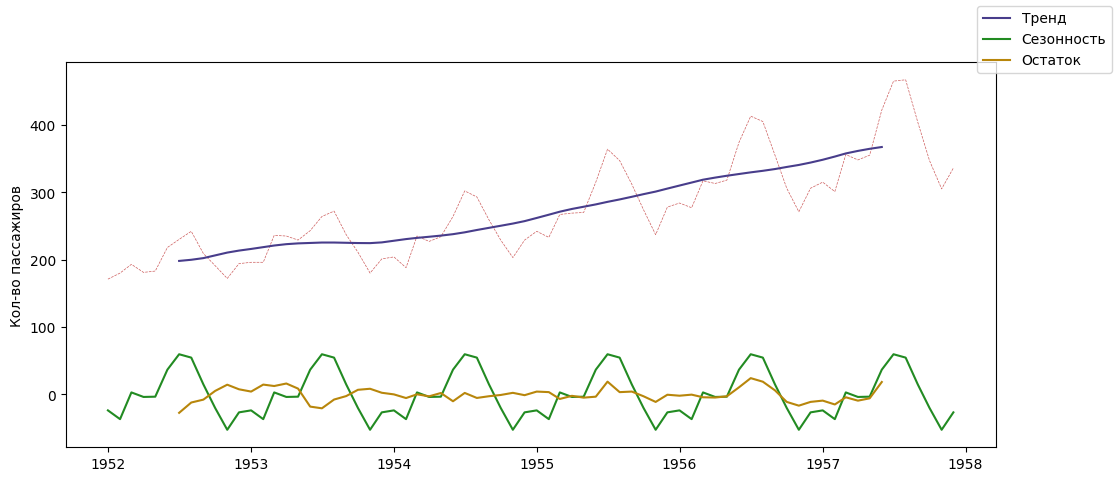

In [46]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data_analytics['#Passengers'], c='indianred', linewidth=0.5, 
        linestyle='--')
ax.plot(trend, c='darkslateblue', label='Тренд')
ax.plot(seasonal, c='forestgreen', label='Сезонность')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Остаток')
ax.set_ylabel('Кол-во пассажиров')

fig.legend()

In [47]:
seasonal.head(24)

Month
1952-01-01   -23.871528
1952-02-01   -36.904861
1952-03-01     2.795139
1952-04-01    -3.929861
1952-05-01    -3.538194
1952-06-01    36.570139
1952-07-01    59.470139
1952-08-01    54.461806
1952-09-01    14.695139
1952-10-01   -20.254861
1952-11-01   -52.679861
1952-12-01   -26.813194
1953-01-01   -23.871528
1953-02-01   -36.904861
1953-03-01     2.795139
1953-04-01    -3.929861
1953-05-01    -3.538194
1953-06-01    36.570139
1953-07-01    59.470139
1953-08-01    54.461806
1953-09-01    14.695139
1953-10-01   -20.254861
1953-11-01   -52.679861
1953-12-01   -26.813194
Name: seasonal, dtype: float64

- Мы наблюдаем восходящий тренд, количество пассажиров увеличивается с каждым годом.
- Годовая сезонность, есть повторяющиеся паттерны (наибольшее число пассажиров в летний период).
- Ряд не является стационарным из-за наличия тренда и сезонности. У стационарного ряда средние и стандартные отклонения не меняются со временем.

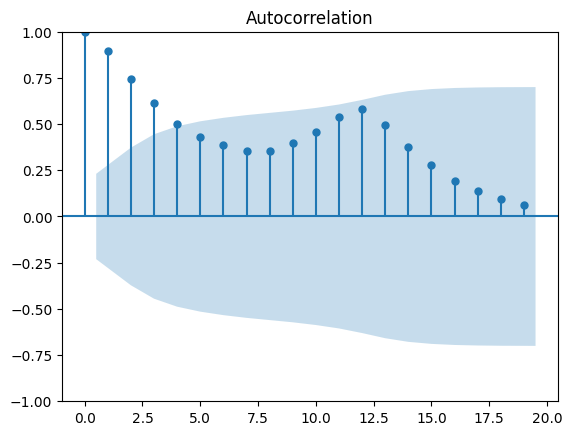

In [48]:
fig = tsaplots.plot_acf(data_analytics['#Passengers'])
plt.show() 

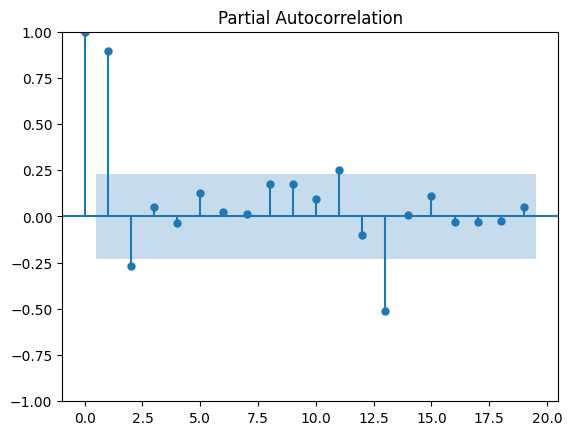

In [49]:
fig = tsaplots.plot_pacf(data_analytics['#Passengers'])

Автокорреляция: первые 4 статистически значимые сдвиги с высокой корреляцией (0.9, 0.75, 0.65, 0.5), далее высок. кор. имеет сдвиг на 12 месяцев (0.55) у границы синего поля (статистич. незнач.). Большинство значений автокорреляции выше нуля, что говорит о наличии положительного тренда. Самая высокая автокорреляция у нулевого сдвига, т.к. наблюдение кор само с собой.  
Частичная автокорреляция показывает, что при учете сильно коррелирующего (около 0,9) сдвига на единицу, высок. кор. и статистическую значимость имеют сдвиги на 2, 11 и 13

3

In [50]:
def make_features(data, lags, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    # сдвиг
    for n in lags:
        data[f'lag_{n}'] = data['#Passengers'].shift(n)
    # размер скользящего среднего окна
    for m in rolling_mean_size:    
        data[f'rolling_mean{m}'] = data['#Passengers'].rolling(m).mean()
        data[f'rolling_mean{m}'] = data[f'rolling_mean{m}'].shift(1)
    
    return data

In [51]:
data_with_features = make_features(df.copy(), [1, 2, 3, 12, 13], [3, 6]).dropna()
data_with_features.head(10)

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_12,lag_13,rolling_mean3,rolling_mean6
Month,,,,,,,,,,,
1952-01-01,171,1952,1,1,166.0,146.0,162.0,145.0,140.0,158.000000,176.000000
1952-02-01,180,1952,2,1,171.0,166.0,146.0,150.0,145.0,161.000000,171.333333
1952-03-01,193,1952,3,1,180.0,171.0,166.0,178.0,150.0,172.333333,168.166667
1952-04-01,181,1952,4,2,193.0,180.0,171.0,163.0,178.0,181.333333,169.666667
1952-05-01,183,1952,5,2,181.0,193.0,180.0,172.0,163.0,184.666667,172.833333
1952-06-01,218,1952,6,2,183.0,181.0,193.0,178.0,172.0,185.666667,179.000000
1952-07-01,230,1952,7,3,218.0,183.0,181.0,199.0,178.0,194.000000,187.666667
1952-08-01,242,1952,8,3,230.0,218.0,183.0,199.0,199.0,210.333333,197.500000
1952-09-01,209,1952,9,3,242.0,230.0,218.0,184.0,199.0,230.000000,207.833333


In [52]:
# разделим данные на признаки и целевую переменную
train, test = train_test_split(data_with_features, shuffle=False, test_size=0.2)

In [53]:
# разделим данные на обучающую и тестовую части
train_target = train['#Passengers']
train_features = train.drop(['#Passengers'], axis=1)
test_target = test['#Passengers']
test_features = test.drop(['#Passengers'], axis=1)

4

In [54]:
scaler = StandardScaler()
scaler.fit(train_features) # приводим к единому масштабу
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

model = LinearRegression() # обучаем модель
model.fit(train_features_norm, train_target)

train_prediction = pd.Series(model.predict(train_features_norm))
train_prediction.index = train_features.index
test_prediction = pd.Series(model.predict(test_features_norm))
test_prediction.index = test_features.index

print("MAE обучающей выборки:", mean_absolute_error(train_target,
                                                     train_prediction))
print("MAE тестовой выборки: ", mean_absolute_error(test_target,
                                                     test_prediction))

MAE обучающей выборки: 7.887286676953509
MAE тестовой выборки:  5.128424202365879


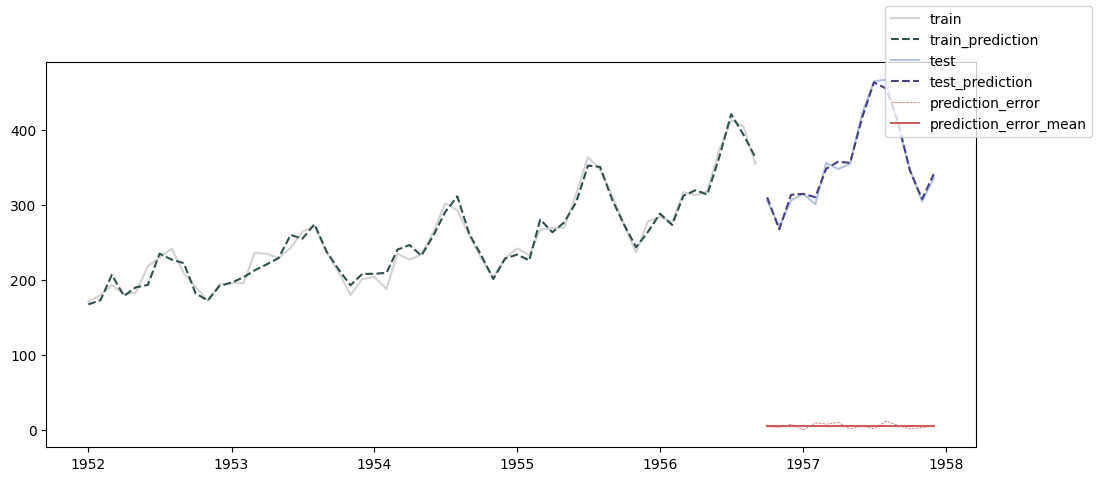

In [55]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['#Passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction',
         linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction',
         linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error',
         linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error_mean')

fig.legend()

In [56]:
# простая модель (предсказ. след. знач. ряда текущим)
pred_previous = test.shift(1).fillna(train.iloc[-1, 0])
# Среднее абсолютное отклонение простой модели
print("MAE:", mean_absolute_error(test, pred_previous))

MAE: 35.6949494949495


In [57]:
pd.DataFrame(zip(train_features.columns, abs(model.coef_)), columns=['feature',
                 'importance']).sort_values(by='importance', ascending=False)

,feature,importance
6,lag_12,49.075477
3,lag_1,42.289595
7,lag_13,36.197791
8,rolling_mean3,11.772336
4,lag_2,8.364762
1,month,5.911735
0,year,5.543744
9,rolling_mean6,4.364442
2,quarter,3.907396
5,lag_3,2.565191


Модель отлично предсказывает, MAE тестовой выборки (=5.1) меньше обучающей (=7.9). Самыми важными признаками (внесли больший вклад) для предсказания значений временного ряда оказались лаг 12 (49%), 1 (42%) и 13 (36%).

5

In [58]:
data_delayed = data['1956-12':'1960']
data_delayed.head(10)

,#Passengers
Month,
1956-12-01,306
1957-01-01,315
1957-02-01,301
1957-03-01,356
1957-04-01,348
1957-05-01,355
1957-06-01,422
1957-07-01,465
1957-08-01,467


In [59]:
data_delayed_with_features = make_features(data_delayed.copy(), 
                                        [1, 2, 3, 12, 13], [3, 6]).dropna()
print(f'Всего {data_delayed_with_features.shape[0]} наблюдений')
print(data_delayed_with_features.index.min(),
       data_delayed_with_features.index.max())

delayed_target = data_delayed_with_features['#Passengers']
delayed_features = data_delayed_with_features.drop(['#Passengers'], axis=1)

# трансформируем отложенную выборку, приводим к единому масштабу
delayed_features_norm = scaler.transform(delayed_features)
n = scaler.get_feature_names_out()
delayed_features_norm = pd.DataFrame(delayed_features_norm, columns= n)

delayed_prediction = pd.Series(model.predict(delayed_features_norm))
delayed_prediction.index = delayed_target.index

print("MAE отложенной выборки:", mean_absolute_error(delayed_target,
                                                      delayed_prediction))

Всего 36 наблюдений
1958-01-01 00:00:00 1960-12-01 00:00:00
MAE отложенной выборки: 12.76104125701117


c:\Users\Танюша\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [60]:
pd.DataFrame(zip(delayed_features_norm.columns, abs(model.coef_)), columns = 
    ['feature', 'importance']).sort_values(by='importance', ascending=False)

,feature,importance
6,lag_12,49.075477
3,lag_1,42.289595
7,lag_13,36.197791
8,rolling_mean3,11.772336
4,lag_2,8.364762
1,month,5.911735
0,year,5.543744
9,rolling_mean6,4.364442
2,quarter,3.907396
5,lag_3,2.565191


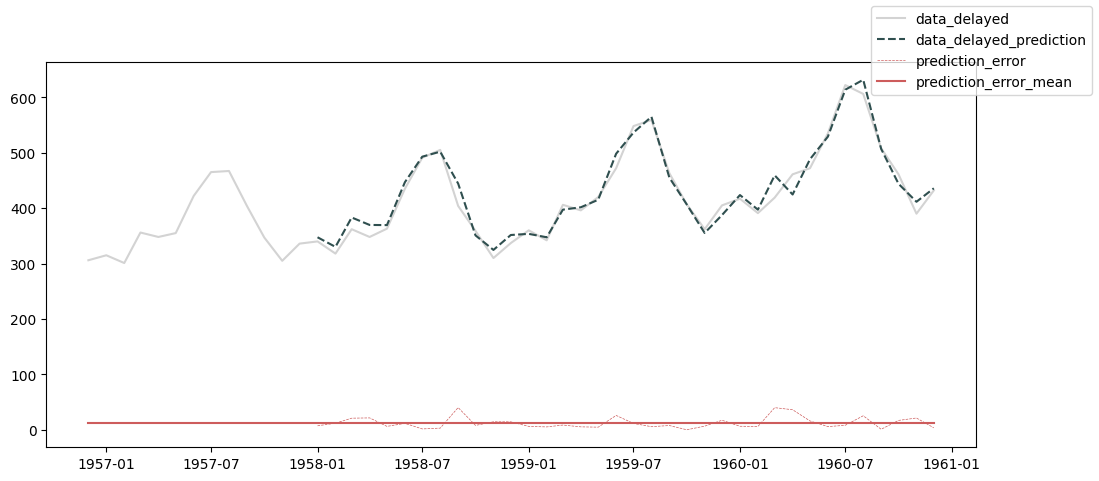

In [61]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(data_delayed ['#Passengers'] - delayed_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = data_delayed['#Passengers'].index

ax.plot(data_delayed ['#Passengers'], c='lightgrey', label='data_delayed')
ax.plot(delayed_prediction, c='darkslategrey', label='data_delayed_prediction',
         linestyle='--')

ax.plot(error, c='indianred', linestyle='--', label='prediction_error',
         linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error_mean')

fig.legend()

Предсказания на отложенной выборке чуть менее точные (MAE отложенной выборки: 12.8 < 35), видим пик ошибок в районе 1960-05 и 1958-09. Модель дает довольно высокие результаты. Наиболее значимые признаки для построения были те же: lag_12, lag_1, lag_13.